In [2]:
import pandas as pd
import os
from bs4 import BeautifulSoup
from more_itertools import unique_everseen
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import matplotlib.cm as cm
import cv2 as cv 
from skimage import feature
import random
from scipy.misc import imresize
from skimage.filters import rank
from skimage.morphology import square,disk

In [3]:
def load_images_from_folder(folder):
    images = {}
    filenames = []
    for filename in os.listdir(folder):
        filenames.append(filename[:-4])
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images[filename[:-4]]=[]
            images[filename[:-4]].append(img)
    return images,filenames
def luminance(image):
    n= image.shape[0]
    m= image.shape[1]
    image = image.reshape(n*m,3)
    for i in range(n*m):
        image[i][0] = np.abs(0.2125*image[i][0] + 0.7154*image[i][1] + 0.0721*image[i][2])
    image = np.delete(image,0,1)
    image = np.delete(image,0,1)
    image = image.reshape(n,m)
    return image
def get_mask_data(images,filenames):
    xml_data =[]
    mask_data={}
    mask_data2={}
    for a in images:
        file = bounding_box_dir + a + '.xml'
        xml =""
        with open(file) as f:
            xml = f.readlines()
            xml = ''.join([line.strip('\t') for line in xml])
            xml_new  = BeautifulSoup(xml,"lxml")
        xml_data.append(xml_new)
    for bd_data in xml_data:
        objs = bd_data.findAll('object')
        for obj in objs:
            obj_names = obj.findChildren('name')
            for name_tag in obj_names:
                fname = bd_data.findChild('filename').contents[0]
                blank_img = np.zeros((images[fname[:-4]][0].shape[0],images[fname[:-4]][0].shape[1]))
                bbox = obj.findChildren('bndbox')[0]
                xmin = int(bbox.findChildren('xmin')[0].contents[0])
                ymin = int(bbox.findChildren('ymin')[0].contents[0])
                xmax = int(bbox.findChildren('xmax')[0].contents[0])
                ymax = int(bbox.findChildren('ymax')[0].contents[0])
                blank_img[xmin:xmax,ymin:ymax] = 1
                if(fname[:-4] not in mask_data):
                    mask_data[fname[:-4]] =[]
                    mask_data2[fname[:-4]] =[]
                mask_data[fname[:-4]].append(blank_img)
                mask_data2[fname[:-4]].append([xmin,ymin,xmax,ymax])
    return mask_data,mask_data2
def show_mask_with_image(filename,images,mask_data2):
    masks = mask_data2[filename]
    image = images[filename][0].copy()
    for mask in masks:
        cv.rectangle(image,(mask[0],mask[1]),(mask[2],mask[3]),(0,0,255),2)
    plt.imshow(image)

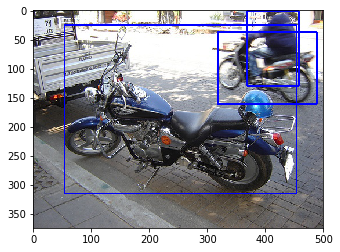

In [4]:
root_dir = '/home/ubuntu/College Assignments/DIP/Project/'
img_dir = os.path.join(root_dir, 'images/')
sample_img_dir = os.path.join(root_dir,'sample_images/')
bounding_box_dir = os.path.join(root_dir,'Boundingbox/')
images,filenames = load_images_from_folder(sample_img_dir) #list of images with each image with 3d and filenames of each image
mask_data,mask_data2 = get_mask_data(images,filenames) #mask_data - imgs with mask portion white and rest black and mask_data2 array of xmin,ymin,xmax,ymax
show_mask_with_image(filenames[20],images,mask_data2)

In [5]:
params={}
params['distribution_windows']=100000
params['min_width']=10
params['min_height']=10
params['ed'] ={}
params['ed']['pixelDistance']=8
params['ed']['imageBorder']=0
params['ed']['theta'] =17

In [1]:
def generateWindows_dense(img,params):
    pixelDistance = params['ed']['pixelDistance']
    imageBorder = params['ed']['imageBorder']
    if(len(img.shape)==3):
        height,width,channels = img.shape
    else:
        height,width = img.shape
    offsetHeight = np.floor(imageBorder * height)
    offsetWidth  = np.floor(imageBorder * width)
    height = int(np.floor(height * (1 - imageBorder)/pixelDistance))
    width  = int(np.floor(width  * (1 - imageBorder)/pixelDistance))
    totalWindows = int(height*width * (height+1) * (width+1)/4)    
    xmin = np.zeros((totalWindows,1))
    xmax = np.zeros((totalWindows,1))
    ymin = np.zeros((totalWindows,1))
    ymax = np.zeros((totalWindows,1))
    currentWindow = 0
    for x in range(1,width+1):
        for y in range(1,height+1):
            for w in range(1,width - x+2 ):
                for h in range(1,height - y+2):                    
                    xmin[currentWindow] = x
                    ymin[currentWindow] = y
                    xmax[currentWindow] = x + w - 1
                    ymax[currentWindow] = y + h - 1
                    currentWindow = currentWindow+1
    xmin = xmin * pixelDistance + offsetWidth
    xmax = xmax * pixelDistance + offsetWidth
    ymin = ymin * pixelDistance + offsetHeight
    ymax = ymax * pixelDistance + offsetHeight
    windows = [xmin,ymin,xmax,ymax]
    return windows

In [69]:
img = images[filenames[0]][0]
windows = generateWindows_uniform(img,params)
print(windows.shape)

(100000, 4)


In [70]:
img = images[filenames[0]][0]
windows = generateWindows_dense(img,params)
#print(windows)
print(windows[0].shape)

(2111193, 1)


# Edge Density Score

In [71]:
def compute_scores(image,xmin,ymin,xmax,ymax):
    windows[windows==0] = 1
    score = np.zeros(len(xmin))
    for i in range(len(xmin)):
        score[i] = image[ymax[i][0]][xmax[i][0]]+image[ymin[i][0]][xmin[i][0]]-image[ymin[i][0]][xmax[i][0]] - image[ymax[i][0]][xmin[i][0]]
    return score
def compute_integral_image(image):  
    image = np.cumsum(image,axis=0)
    image = np.cumsum(image,axis=1)
    pad_image = np.zeros((image.shape[0]+1,image.shape[1]+1))
    pad_image = image[1:,1:]
    return pad_image
def edge_density_score(image,params):
    channels = image.shape[2]
    theta = params['ed']['theta']    
    if channels==3:
        image = luminance(image)
    edge_image = feature.canny(image)
    integral_image = compute_integral_image(edge_image)
    windows = generateWindows_dense(integral_image,params=params)
    xmin = (windows[0]).astype(int)
    ymin = (windows[1]).astype(int)
    xmax = (windows[2]).astype(int)
    ymax = (windows[3]).astype(int)
    xmax_inner = (np.round((xmax*(200+theta)/(theta+100) + xmin*theta/(theta+100)+100/(theta+100)-1)/2)).astype(int)
    xmin_inner = (np.round(xmax+xmin-xmax_inner)).astype(int)
    ymax_inner = (np.round((ymax*(200+theta)/(theta+100) + ymin*theta/(theta+100)+100/(theta+100)-1)/2)).astype(int)
    ymin_inner = (np.round(ymax+ymin-ymax_inner)).astype(int)
    score_windows = compute_scores(integral_image,xmin,ymin,xmax,ymax)
    score_inner_windows = compute_scores(integral_image,xmin_inner,ymin_inner,xmax_inner,ymax_inner)
    area_windows = (xmax-xmin+1) * (ymax-ymin+1)
    area_inner_windows = (xmax_inner - xmin_inner +1) * (ymax_inner -ymin_inner +1)
    area_diff = area_windows - area_inner_windows
    area_diff[area_diff==0] = 100000000   
    score = np.zeros((len(xmax),1))
    for i in range(len(score)):
        score[i] = ((xmax[i]-xmax_inner[i]+ymax[i]-ymax_inner[i])*(score_windows[i]-score_inner_windows[i])/area_diff[i])
    boxes = [windows,score]
    return boxes

In [72]:
img = images[filenames[0]][0]
boxes = edge_density_score(img,params)

In [73]:
print(len(np.unique(boxes[1])))

446852


# Multi Scale Saliency

In [74]:
params['MS'] = {}
params['MS']['scale'] = [16,24,32,48,64]
params['MS']['theta'] = [0.43,0.32,0.34,0.35,0.26]
params['min_window_height'] = 10
params['min_window_width']  = 10
params['distribution_windows']=100000
params['MS']['filter_size'] = 3

In [82]:
def saliency_map_channel(img,channel,params,scale):
    filter_size = params['MS']['filter_size']
    img = img[:,:,channel]
    norm_img = cv.normalize(img.astype('float'),None,0.0,1.0,cv.NORM_MINMAX)
    resized_img = imresize(norm_img,(scale,scale),interp='bilinear')
    f = np.fft.fft2(img)
    filter1 = square(filter_size)
    filter2 = disk(filter_size)
    log_amplitude = np.log(np.absolute(f))/255
    phase = np.angle(f)
    smooth = rank.mean(log_amplitude, selem=filter1)
    spectral_residual = log_amplitude - smooth
    saliency_map = np.absolute(np.fft.ifft(np.exp(spectral_residual +1+ phase)))**2
    saliency_map = rank.mean(saliency_map, selem=filter2)
    #plt.imshow(saliency_map,cmap=cm.gray)
    return saliency_map    
def sliding_window_compute_score(saliency_map,scale,min_width,min_height,threshold,sal_integral_image,thr_integral_image):
    score_scale = np.zeros((scale*scale,scale*scale))
    image_area = scale*scale
    for i in range(0,scale-min_width+1):
        for j in range(0,scale-min_height+1):
            for k in range(i+min_width-1,scale+1):
                for l in range(j+min_height-1,scale+1):
                    area = (k-i+1)*(l-j+1)
                    aval = sal_integral_image[k][l]+sal_integral_image[i][j]-sal_integral_image[k][j]-sal_integral_image[i][l]
                    athr = thr_integral_image[k][l]+thr_integral_image[i][j]-thr_integral_image[k][j]-thr_integral_image[i][l]
                    score_scale[scale*j+l][scale*i+k] = aval*athr/area    
    return score_scale
def retrieve_coordinates(index,scale):
    image_area = scale*scale
    index1 = index%image_area
    index2 = np.floor(index/image_area)
    x1 = index1%scale + 1
    y1 = np.floor(index1/scale)+1
    x2 = index2%scale + 1
    y1 = np.floor(index2/scale)+1
    return x1,y1,x2,y2   
def MS_score(img,params):
    xmin = [];ymin = [];xmax = [];ymax = [];score = []
    height,width,channels = img.shape
    scales = params['MS']['scale']
    theta = params['MS']['theta']
    min_window_height = params['min_window_height'] 
    min_window_width = params['min_window_width']
    distribution_windows = params['distribution_windows']
    filter_size = params['MS']['filter_size']
    for i in range(len(scales)):
        scale = scales[i]
        threshold = theta[i]
        min_width = max(2,np.round(min_window_width*scale/width ))
        min_height = max(2,np.round(min_window_height*scale/height))
        samples = np.round(distribution_windows/(len(scales)*3))
        for j in range(channels):
            saliency_map = saliency_map_channel(img,j,params,scale)
            thr_map = saliency_map >=threshold
            sal_map = np.multiply(saliency_map,thr_map)
            thr_integral_image = compute_integral_image(thr_map)
            sal_integral_image = compute_integral_image(sal_map)
            score_scale = sliding_window_compute_score(saliency_map,scale,min_width,min_height,threshold,sal_integral_image,thr_integral_image)
            index_positives = np.argwhere(score_scale>0)
            score_scale = score_scale[index_positives]
            index_samples = score_sampling(score_scale,samples,1)
            score_scale = score_scale[index_samples]
            xmin_scale,ymin_scale,xmax_scale,ymax_scale = retrieve_coordinates(index_positives[index_samples]-1,scale)
            xmin_scale = xmin_scale*width/scale
            ymin_scale = ymin_scale*height/scale
            xmax_scale = xmax_scale*width/scale
            ymax_scale = ymax_scale*height/scale
            score.append(score_scale)
            xmin.append(xmin_scale)
            ymin.append(ymin_scale)
            xmax.append(xmax_scale)
            ymax.append(ymax_scale)
    boxes = [xmin,ymin,xmax,ymax,score]
    boxes = boxes[:distribution_windows,:]
    return boxes
    
    

# Sampling

In [102]:
def score_sampling(score_vector,number_samples,option):
    length_score_vector = max(score_vector.shape[0],score_vector.shape[1])
    print(length_score_vector)
    index = np.zeros((int(number_samples)))
    cum_sum = np.zeros((int(length_score_vector)))
    score_vector_copy = np.zeros((int(length_score_vector)))
    cumsum[0] = score_vector[0]
    for i in range(1,length_score_vector):
        cumsum[i] = cumsum[i-1] + score_vector[i]
    for i in range(length_score_vector):
        score_vector_copy[i] = score_vector[i]
    for i in range(number_samples):
        r = random.random()*cumsum[length_score_vector-1]
        minim =0
        maxim = length_score_vector-1
        interval_length = maxim - minim + 1
        while(interval_length >2):
            middle = np.floor((minim+maxim)/2)
            if(cumsum[middle]>r):
                maxim = middle
            else:
                minim = middle
            interval_length = maxim-minim+1
        if(cumsum[minim]>r):
            index[i] = minim
        else:
            index[i] = maxim
        if(option ==0):
            j=np.floor(index[i])
            score_vector_copy[i] = 0
            cumsum[0] = score_vector_copy[0]
            for j in range(1,length_score_vector):
                cumsum[j] = cumsum[j-1] + score_vector_copy[j]                
    for i in range(number_samples):
        index[i] = index[i] +1
    return index

In [ ]:
img = images[filenames[2]][0]
#plt.imshow(img)
MS_score(img,params)